# Morpho-VC HEST single-slide training (INT25 -> INT28)

This notebook runs the Morpho-VC MIL pipeline on HEST prostate slides.
- Fixed test slide: INT28
- Single-slide training: INT25
- Validation: blocked grid split within INT25 (quadrant-balanced)
- Global geneset: intersection across INT25/INT26/INT27/INT28/INT35

Outputs are written to the archive path under results/prostate_hest.


In [ ]:
from pathlib import Path
import os
import sys
import json
import time
import warnings

warnings.filterwarnings("ignore")

ROOT = Path(os.environ.get("MORPHO_VC_ROOT", "../")).expanduser().resolve(strict=False)
print(f"ROOT: {ROOT} | exists={ROOT.exists()}")
if not ROOT.exists():
    raise FileNotFoundError(f"ROOT not found: {ROOT}")
os.chdir(ROOT)
sys.path.append(str(ROOT / "src"))

hest_src = ROOT / "third_party" / "HEST" / "src"
if hest_src.exists():
    sys.path.insert(0, str(hest_src))

# Data directories

data_dir = ROOT / "data"
hest_dir = data_dir / "hest_data"
spatial_dir = data_dir / "spatial_data"
cell_csv_dir = data_dir / "cell_centers"
cell_patch_dir = data_dir / "cell_images"
cell_emb_dir = data_dir / "cell_embeddings"
spot_map_dir = data_dir / "spot_cell_maps"

# CellFM vocab + checkpoint

gene_vocab_path = ROOT / "assets" / "cellfm" / "expand_gene_info.csv"
cellfm_checkpoint = ROOT / "checkpoints" / "CellFM" / "CellFM_80M_weight.pt"

# Slides

slide_ids_all = ["INT25", "INT26", "INT27", "INT28", "INT35"]
train_slide_id = "INT25"
test_slide_id = "INT28"

# Download toggle

RUN_DOWNLOAD = True
hf_token = ""

# LazySlide embedding

lazyslide_model = "resnet50"
lazyslide_model_path = ROOT / "checkpoints" / "ResNet" / "model.safetensors"

# Geneset

geneset_dir = spatial_dir / "genesets"
GENESET_ID = "prostate_hest_v1_INT25_INT26_INT27_INT28_INT35"
geneset_path = geneset_dir / f"{GENESET_ID}.txt"

# Results

RESULTS_ROOT = ROOT / "results" / "prostate_hest" / "morpho"
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)


def _check_path(label, p):
    p = Path(p)
    print(f"{label}: {p} | exists={p.exists()}")
    return p.exists()


def _check_slide(sid):
    st_path = hest_dir / "st" / f"{sid}.h5ad"
    meta_path = hest_dir / "metadata" / f"{sid}.json"
    wsis_dir = hest_dir / "wsis"
    wsi_match = None
    if wsis_dir.exists():
        matches = list(wsis_dir.glob(f"{sid}.*"))
        wsi_match = matches[0] if matches else None
    print(f"[{sid}] st: {st_path.exists()} | meta: {meta_path.exists()} | wsi: {bool(wsi_match)}")

    h5ad_out = spatial_dir / f"{sid}.h5ad"
    cell_csv = cell_csv_dir / f"{sid}_cells.csv"
    cell_patch_h5 = cell_patch_dir / f"{sid}_cell_patches.h5"
    cell_emb_h5 = cell_emb_dir / f"{sid}_cell_emb.h5"
    print(
        f"    processed h5ad: {h5ad_out.exists()} | "
        f"cells.csv: {cell_csv.exists()} | patches: {cell_patch_h5.exists()} | emb: {cell_emb_h5.exists()}"
    )


print("=== Base paths ===")
_check_path("data_dir", data_dir)
_check_path("hest_dir", hest_dir)
_check_path("spatial_dir", spatial_dir)
_check_path("cell_csv_dir", cell_csv_dir)
_check_path("cell_patch_dir", cell_patch_dir)
_check_path("cell_emb_dir", cell_emb_dir)
_check_path("spot_map_dir", spot_map_dir)
_check_path("gene_vocab_path", gene_vocab_path)
_check_path("cellfm_checkpoint", cellfm_checkpoint)

if lazyslide_model_path:
    _check_path("lazyslide_model_path", lazyslide_model_path)

print("=== Slide check ===")
for sid in slide_ids_all:
    _check_slide(sid)


In [ ]:
from st_pipeline.data.hest_raw import download_hest

if RUN_DOWNLOAD:
    download_hest(hest_dir=hest_dir, slide_ids=slide_ids_all, token=hf_token)
else:
    print("Skipping download: make sure data/hest_data has required slides")


In [3]:
from st_pipeline.data.hest_raw import (
    export_h5ad_from_hest,
    export_cells_csv_from_hest,
    export_cell_patches_from_hest,
)
from st_pipeline.data.cell_embed_lazyslide import EmbedConfig, embed_cells


def ensure_slide_outputs(slide_id: str):
    h5ad_out = spatial_dir / f"{slide_id}.h5ad"
    cell_csv = cell_csv_dir / f"{slide_id}_cells.csv"
    cell_patch_h5 = cell_patch_dir / f"{slide_id}_cell_patches.h5"
    cell_emb_h5 = cell_emb_dir / f"{slide_id}_cell_emb.h5"

    if not h5ad_out.exists():
        export_h5ad_from_hest(hest_dir=hest_dir, slide_id=slide_id, output_h5ad=h5ad_out)
    if not cell_csv.exists():
        export_cells_csv_from_hest(hest_dir=hest_dir, slide_id=slide_id, output_csv=cell_csv)
    if not cell_patch_h5.exists():
        export_cell_patches_from_hest(
            hest_dir=hest_dir,
            slide_id=slide_id,
            output_h5=cell_patch_h5,
            shape_name="cellvit",
            coordinates_name="he",
            target_patch_size=72,
            target_pixel_size=0.25,
        )
    if not cell_emb_h5.exists():
        cfg = EmbedConfig(
            model_name=lazyslide_model,
            model_path=lazyslide_model_path,
            device="cuda",
            batch_size=64,
            num_workers=4,
        )
        embed_cells(cell_patch_h5=cell_patch_h5, output_h5=cell_emb_h5, config=cfg)
    return h5ad_out, cell_emb_h5


for sid in slide_ids_all:
    ensure_slide_outputs(sid)

print("All slides have h5ad and cell embeddings.")


All slides have h5ad and cell embeddings.


In [4]:
import scanpy as sc
from st_pipeline.data.gene_vocab import load_gene_vocab

vocab = set(load_gene_vocab(gene_vocab_path))
gene_sets = []
for sid in slide_ids_all:
    h5ad_path = spatial_dir / f"{sid}.h5ad"
    adata = sc.read_h5ad(h5ad_path)
    gene_sets.append(set(adata.var_names) & vocab)

common_genes = sorted(set.intersection(*gene_sets))
if not common_genes:
    raise ValueError("Common genes are empty. Check vocab and datasets.")

geneset_dir.mkdir(parents=True, exist_ok=True)
geneset_path.write_text("\n".join(common_genes), encoding="utf-8")

print("Common genes:", len(common_genes))
print("Saved geneset:", geneset_path)


Common genes: 17512
Saved geneset: D:\code\Morpho-VC\data\spatial_data\genesets\prostate_hest_v1_INT25_INT26_INT27_INT28_INT35.txt


In [5]:
from st_pipeline.data.h5ad_loader import load_h5ad
from st_pipeline.data.mil_dataset import MilSpotDataset

spot_map_dir.mkdir(parents=True, exist_ok=True)


def build_dataset(slide_id: str):
    h5ad_path = spatial_dir / f"{slide_id}.h5ad"
    emb_path = cell_emb_dir / f"{slide_id}_cell_emb.h5"
    map_path = spot_map_dir / f"{slide_id}_spot_cell_map.json"

    data = load_h5ad(
        h5ad_path=h5ad_path,
        genes=common_genes,
        spot_radius_px=0,
        gene_vocab_path=gene_vocab_path,
    )
    ds = MilSpotDataset(
        adata=data.adata,
        embedding_h5=emb_path,
        spot_radius_px=data.spot_radius_px,
        gene_ids=data.gene_ids,
        mapping_json=map_path,
    )
    return data, ds


datasets = {}
datas = {}

for sid in [train_slide_id, test_slide_id]:
    data, ds = build_dataset(sid)
    datasets[sid] = ds
    datas[sid] = data

print("Train slide:", train_slide_id)
print("Test slide:", test_slide_id)


Train slide: INT25
Test slide: INT28


In [6]:
import numpy as np
from torch.utils.data import Subset


def _coords_for_dataset(ds):
    adata = ds.adata
    name_to_idx = {sid: i for i, sid in enumerate(adata.obs_names)}
    coords = np.array([adata.obsm["spatial"][name_to_idx[sid]] for sid in ds.spot_ids], dtype=np.float32)
    return coords


def _compute_blocks(coords, grid_size):
    min_x, min_y = coords.min(axis=0)
    max_x, max_y = coords.max(axis=0)
    span_x = max_x - min_x + 1e-6
    span_y = max_y - min_y + 1e-6
    gx = np.floor((coords[:, 0] - min_x) / span_x * (grid_size - 1)).astype(int)
    gy = np.floor((coords[:, 1] - min_y) / span_y * (grid_size - 1)).astype(int)
    gx = np.clip(gx, 0, grid_size - 1)
    gy = np.clip(gy, 0, grid_size - 1)

    blocks = {}
    for i, (bx, by) in enumerate(zip(gx, gy)):
        bid = (int(bx), int(by))
        blocks.setdefault(bid, []).append(i)
    return blocks


def _select_grid_size(coords, min_grid=4, max_grid=10, min_blocks=20, max_blocks=80):
    target = (min_blocks + max_blocks) / 2.0
    candidates = []
    for g in range(min_grid, max_grid + 1):
        blocks = _compute_blocks(coords, g)
        n_blocks = len(blocks)
        in_range = min_blocks <= n_blocks <= max_blocks
        score = 0 if in_range else abs(n_blocks - target)
        candidates.append((in_range, score, g, blocks, n_blocks))
    candidates.sort(key=lambda x: (0 if x[0] else 1, x[1]))
    in_range, score, grid_size, blocks, n_blocks = candidates[0]
    return grid_size, blocks, n_blocks


def make_blocked_split(
    ds,
    val_ratio=0.2,
    seed=42,
    grid_size=None,
    min_grid=4,
    max_grid=10,
    min_blocks=20,
    max_blocks=80,
):
    coords = _coords_for_dataset(ds)
    n_spots = coords.shape[0]

    if grid_size is None:
        grid_size, blocks, block_count = _select_grid_size(
            coords,
            min_grid=min_grid,
            max_grid=max_grid,
            min_blocks=min_blocks,
            max_blocks=max_blocks,
        )
    else:
        blocks = _compute_blocks(coords, grid_size)
        block_count = len(blocks)

    if block_count < 2:
        raise ValueError("Not enough blocks to create a validation split.")

    block_sizes = {bid: len(idxs) for bid, idxs in blocks.items()}
    med_x, med_y = np.median(coords[:, 0]), np.median(coords[:, 1])

    quadrants = {0: [], 1: [], 2: [], 3: []}
    for bid, idxs in blocks.items():
        center = coords[idxs].mean(axis=0)
        qx = 0 if center[0] < med_x else 1
        qy = 0 if center[1] < med_y else 1
        q = qx + 2 * qy
        quadrants[q].append(bid)

    val_blocks = set()
    target_total = max(1, int(round(n_spots * val_ratio)))

    for q in range(4):
        block_ids = quadrants[q]
        if len(block_ids) < 2:
            continue
        rng_q = np.random.default_rng(seed + q + 1)
        block_ids = block_ids.copy()
        rng_q.shuffle(block_ids)

        total_q = sum(block_sizes[bid] for bid in block_ids)
        target_q = int(round(total_q * val_ratio))
        if target_q == 0:
            target_q = 1

        selected_q = []
        picked = 0
        for bid in block_ids:
            if len(selected_q) >= len(block_ids) - 1:
                break
            selected_q.append(bid)
            picked += block_sizes[bid]
            if picked >= target_q:
                break

        val_blocks.update(selected_q)

    val_count = sum(block_sizes[bid] for bid in val_blocks)
    if val_count < target_total:
        remaining = [bid for bid in blocks.keys() if bid not in val_blocks]
        remaining.sort(key=lambda b: block_sizes[b], reverse=True)
        for bid in remaining:
            if len(val_blocks) >= len(blocks) - 1:
                break
            val_blocks.add(bid)
            val_count += block_sizes[bid]
            if val_count >= target_total:
                break

    val_indices = []
    for bid in val_blocks:
        val_indices.extend(blocks[bid])
    val_indices = sorted(set(val_indices))
    val_set = set(val_indices)
    train_indices = [i for i in range(n_spots) if i not in val_set]

    actual_ratio = len(val_indices) / max(n_spots, 1)

    meta = {
        "strategy": "blocked_grid_quadrant",
        "grid_size": grid_size,
        "block_count": block_count,
        "val_ratio_target": val_ratio,
        "val_ratio_actual": actual_ratio,
        "min_grid": min_grid,
        "max_grid": max_grid,
        "min_blocks": min_blocks,
        "max_blocks": max_blocks,
        "seed": seed,
        "val_blocks": sorted([f"{b[0]}_{b[1]}" for b in val_blocks]),
    }
    return train_indices, val_indices, meta


VAL_RATIO = 0.2
SEED = 42
GRID_SIZE = None  # auto

train_base = datasets[train_slide_id]
train_indices, val_indices, split_meta = make_blocked_split(
    train_base,
    val_ratio=VAL_RATIO,
    seed=SEED,
    grid_size=GRID_SIZE,
)

train_ds = Subset(train_base, train_indices)
val_ds = Subset(train_base, val_indices)

test_ds = datasets[test_slide_id]

train_spot_ids = [train_base.spot_ids[i] for i in train_indices]
val_spot_ids = [train_base.spot_ids[i] for i in val_indices]

test_spot_ids = list(test_ds.spot_ids)

print(f"Train spots: {len(train_ds)} | Val spots: {len(val_ds)}")
print(f"Blocked grid size: {split_meta['grid_size']} | Blocks: {split_meta['block_count']}")
print(f"Val ratio target: {VAL_RATIO:.2f} | actual: {split_meta['val_ratio_actual']:.4f}")


Train spots: 2476 | Val spots: 940
Blocked grid size: 6 | Blocks: 27
Val ratio target: 0.20 | actual: 0.2752


In [7]:
import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from st_pipeline.data.collate import mil_collate
from st_pipeline.data.gene_vocab import load_gene_vocab
from st_pipeline.constants import KEYS
from st_pipeline.model.nb_loss import nb_negative_log_likelihood
from st_pipeline.model.morpho_cellfm_mil import MorphoCellfmMIL

# Training config

RUN_TRAIN = False
batch_size = 8
num_workers = 4
epochs = 100
lr = 1e-4
gene_chunk_size = 512
heartbeat_batches = 5

# Optimization

gene_lr_mult = 3.0
use_amp = True
resume_training = False

# Early stopping

early_stop_patience = 5
early_stop_min_delta = 1e-4
no_improve = 0

# DDP init (use torchrun to enable)

def init_ddp():
    if "RANK" in os.environ and "WORLD_SIZE" in os.environ:
        rank = int(os.environ["RANK"])
        world_size = int(os.environ["WORLD_SIZE"])
        local_rank = int(os.environ.get("LOCAL_RANK", 0))
        backend = "nccl" if torch.cuda.is_available() else "gloo"
        dist.init_process_group(backend=backend, init_method="env://")
        if torch.cuda.is_available():
            torch.cuda.set_device(local_rank)
        return True, rank, world_size, local_rank
    return False, 0, 1, 0


is_ddp, rank, world_size, local_rank = init_ddp()
cuda_count = torch.cuda.device_count()

if is_ddp:
    device = torch.device(f"cuda:{local_rank}" if torch.cuda.is_available() else "cpu")
    print(f"DDP enabled: rank={rank}/{world_size}, local_rank={local_rank}, device={device}")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if cuda_count > 1:
        print(f"Detected {cuda_count} GPUs but DDP is disabled; using {device}.")
    else:
        print(f"Single device: {device}")

if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

train_sampler = None
val_sampler = None
if is_ddp:
    train_sampler = DistributedSampler(train_ds, num_replicas=world_size, rank=rank, shuffle=True)
    val_sampler = DistributedSampler(val_ds, num_replicas=world_size, rank=rank, shuffle=False)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=(train_sampler is None),
    sampler=train_sampler,
    num_workers=num_workers,
    collate_fn=mil_collate,
    pin_memory=(device.type == "cuda"),
    persistent_workers=(num_workers > 0),
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    sampler=val_sampler,
    num_workers=num_workers,
    collate_fn=mil_collate,
    pin_memory=(device.type == "cuda"),
    persistent_workers=(num_workers > 0),
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=mil_collate,
    pin_memory=(device.type == "cuda"),
    persistent_workers=(num_workers > 0),
)

# Model input size

sample_emb_path = cell_emb_dir / f"{train_slide_id}_cell_emb.h5"
with __import__("h5py").File(sample_emb_path, "r") as f:
    input_dim = int(f["embedding"].shape[1])

vocab_size = len(load_gene_vocab(gene_vocab_path))

model_config = {
    "input_dim": input_dim,
    "n_genes": len(common_genes),
    "cellfm_dim": 1536,
    "cellfm_layers": 2,
    "cellfm_heads": 48,
    "cellfm_checkpoint": str(cellfm_checkpoint),
    "freeze_cellfm": True,
    "use_mock": False,
    "use_retention": True,
    "vocab_size": vocab_size,
    "dropout": 0.1,
    "aggregation": "mean",
    "dispersion": "gene",
}

model = MorphoCellfmMIL(**model_config).to(device)

# Unfreeze gene-side parameters only
for p in model.cellfm.model.parameters():
    p.requires_grad = False
model.cellfm.model.gene_emb.requires_grad = True
for p in model.cellfm.model.cellwise_dec.map.parameters():
    p.requires_grad = True
model.gene_dispersion.requires_grad = True

# RUN_TAG = os.environ.get("RUN_TAG") or time.strftime("%Y%m%d-%H%M%S")
RUN_TAG = 1
# run_dir = RESULTS_ROOT / "single" / (
#     f"{RUN_TAG}__train-{train_slide_id}__test-{test_slide_id}__"
#     f"val-blocked-g{split_meta['grid_size']}_seed{SEED}__geneset-{GENESET_ID}"
# )
run_dir = RESULTS_ROOT / "single" / "INT25_to_INT28"
run_dir.mkdir(parents=True, exist_ok=True)
ckpt_dir = run_dir / "checkpoints"
ckpt_dir.mkdir(parents=True, exist_ok=True)

# Save config and split info

config = {
    "train_slide_id": train_slide_id,
    "test_slide_id": test_slide_id,
    "slide_ids_all": slide_ids_all,
    "val_strategy": split_meta["strategy"],
    "val_ratio": VAL_RATIO,
    "val_seed": SEED,
    "grid_size": split_meta["grid_size"],
    "geneset_id": GENESET_ID,
    "geneset_path": str(geneset_path),
    "run_dir": str(run_dir),
    "model": model_config,
    "train": {
        "batch_size": batch_size,
        "num_workers": num_workers,
        "epochs": epochs,
        "lr": lr,
        "gene_chunk_size": gene_chunk_size,
        "gene_lr_mult": gene_lr_mult,
        "use_amp": use_amp,
        "resume_training": resume_training,
        "early_stop_patience": early_stop_patience,
        "early_stop_min_delta": early_stop_min_delta,
    },
}
run_dir.joinpath("config.json").write_text(json.dumps(config, indent=2), encoding="utf-8")
run_dir.joinpath("genes.txt").write_text("\n".join(common_genes), encoding="utf-8")

split_info = {
    "train_slide_id": train_slide_id,
    "test_slide_id": test_slide_id,
    "val_strategy": split_meta["strategy"],
    "val_ratio": VAL_RATIO,
    "val_seed": SEED,
    "grid_size": split_meta["grid_size"],
    "block_count": split_meta["block_count"],
    "val_ratio_actual": split_meta["val_ratio_actual"],
    "val_blocks": split_meta["val_blocks"],
    "train_spot_ids": train_spot_ids,
    "val_spot_ids": val_spot_ids,
}
run_dir.joinpath("split.json").write_text(json.dumps(split_info, indent=2), encoding="utf-8")

best_val = 1e9

if is_ddp:
    model = DDP(model, device_ids=[local_rank] if torch.cuda.is_available() else None)

base_model = model.module if is_ddp else model

resume_path = ckpt_dir / "best_model.pt"
if resume_training and resume_path.exists():
    base_model.load_state_dict(torch.load(resume_path, map_location=device))
    if (not is_ddp) or rank == 0:
        print(f"Resumed training from {resume_path}")

optimizer = torch.optim.AdamW(
    [
        {"params": [base_model.cellfm.model.gene_emb], "lr": lr * gene_lr_mult},
        {"params": base_model.cellfm.model.cellwise_dec.map.parameters(), "lr": lr * gene_lr_mult},
        {"params": base_model.adapter.parameters(), "lr": lr},
        {"params": [base_model.gene_dispersion], "lr": lr},
    ],
    weight_decay=1e-2,
)

use_amp = bool(use_amp and device.type == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

if (not is_ddp) or rank == 0:
    trainable = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
    print(f"Trainable params: {trainable}")
    print(f"Run dir: {run_dir}")

# Gene chunks to reduce memory

gene_count = len(common_genes)
if gene_chunk_size <= 0:
    raise ValueError("gene_chunk_size must be > 0")

gene_chunks = [
    list(range(i, min(i + gene_chunk_size, gene_count)))
    for i in range(0, gene_count, gene_chunk_size)
]
print("Genes:", gene_count, "Chunks:", len(gene_chunks), "Chunk size:", gene_chunk_size)


def ddp_reduce(total: float, steps: int):
    if not is_ddp:
        return total, steps
    t = torch.tensor([total, steps], device=device)
    dist.all_reduce(t, op=dist.ReduceOp.SUM)
    return float(t[0].item()), int(t[1].item())


if RUN_TRAIN:
    for epoch in range(1, epochs + 1):
        if train_sampler is not None:
            train_sampler.set_epoch(epoch)

        model.train()
        total = 0.0
        steps = 0
        for batch_idx, batch in enumerate(train_loader):
            for k in batch:
                batch[k] = batch[k].to(device)

            chunk_order = torch.randperm(len(gene_chunks)).tolist()
            for ci in chunk_order:
                idx = torch.as_tensor(gene_chunks[ci], device=device)
                batch_chunk = {
                    KEYS.X: batch[KEYS.X],
                    KEYS.PTR_BAG_INSTANCE: batch[KEYS.PTR_BAG_INSTANCE],
                    KEYS.SIZE_FACTOR: batch[KEYS.SIZE_FACTOR],
                    KEYS.GENE_IDS: batch[KEYS.GENE_IDS][idx],
                    KEYS.Y_BAG: batch[KEYS.Y_BAG][:, idx],
                }
                optimizer.zero_grad(set_to_none=True)
                with torch.cuda.amp.autocast(enabled=use_amp):
                    mu_bag, _ = model(batch_chunk)
                    theta = torch.exp(base_model.gene_dispersion[idx])
                    loss = nb_negative_log_likelihood(batch_chunk[KEYS.Y_BAG], mu_bag, theta)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                total += float(loss.item())
                steps += 1

            if ((not is_ddp) or rank == 0) and batch_idx % heartbeat_batches == 0:
                print(f"epoch {epoch} batch {batch_idx}/{len(train_loader)}", flush=True)

        total, steps = ddp_reduce(total, steps)
        train_loss = total / max(steps, 1)

        model.eval()
        total = 0.0
        steps = 0
        with torch.no_grad():
            for batch in val_loader:
                for k in batch:
                    batch[k] = batch[k].to(device)
                for ci in range(len(gene_chunks)):
                    idx = torch.as_tensor(gene_chunks[ci], device=device)
                    batch_chunk = {
                        KEYS.X: batch[KEYS.X],
                        KEYS.PTR_BAG_INSTANCE: batch[KEYS.PTR_BAG_INSTANCE],
                        KEYS.SIZE_FACTOR: batch[KEYS.SIZE_FACTOR],
                        KEYS.GENE_IDS: batch[KEYS.GENE_IDS][idx],
                        KEYS.Y_BAG: batch[KEYS.Y_BAG][:, idx],
                    }
                    with torch.cuda.amp.autocast(enabled=use_amp):
                        mu_bag, _ = model(batch_chunk)
                        theta = torch.exp(base_model.gene_dispersion[idx])
                        loss = nb_negative_log_likelihood(batch_chunk[KEYS.Y_BAG], mu_bag, theta)
                    total += float(loss.item())
                    steps += 1

        total, steps = ddp_reduce(total, steps)
        val_loss = total / max(steps, 1)

        if (not is_ddp) or rank == 0:
            print(f"Epoch {epoch}: train={train_loss:.4f} val={val_loss:.4f}")

        should_stop = False
        if (not is_ddp) or rank == 0:
            if val_loss < best_val - early_stop_min_delta:
                best_val = val_loss
                no_improve = 0
                ckpt_path = ckpt_dir / "best_model.pt"
                torch.save(base_model.state_dict(), ckpt_path)
                print("Saved best model:", ckpt_path)
            else:
                no_improve += 1
                if no_improve >= early_stop_patience:
                    should_stop = True
                    print(f"Early stop: {no_improve} epochs without improvement")

        if is_ddp:
            flag = torch.tensor(1 if should_stop else 0, device=device)
            dist.broadcast(flag, src=0)
            should_stop = bool(flag.item())

        if should_stop:
            break

    if is_ddp:
        dist.destroy_process_group()


Single device: cuda:0


Skipped 1 CellFM keys due to shape mismatch.
Missing CellFM keys: ['value_enc.value_enc.a']


Trainable params: 50674792
Run dir: D:\code\Morpho-VC\results\prostate_hest\morpho\single\INT25_to_INT28
Genes: 17512 Chunks: 35 Chunk size: 512


In [ ]:
import numpy as np
from st_pipeline.constants import KEYS

# ============================================================
# 目的：如果 run_dir 下已经存在预测结果（pred_bag/true_bag/spots），则直接加载
#      否则才进行预测并保存。
#      DDP 场景：rank0 负责预测与保存；其他 rank 等待 barrier 后加载。
# ============================================================

RUN_PREDICT = True  # 你仍然可以用这个开关强制预测（但默认会优先走“已有结果检测/加载”）

pred_path = Path(run_dir) / "pred_bag.npy"
true_path = Path(run_dir) / "true_bag.npy"
spots_path = Path(run_dir) / "spots.csv"


def _atomic_save_npy(path: Path, arr: np.ndarray):
    path.parent.mkdir(parents=True, exist_ok=True)
    tmp = path.with_suffix(path.suffix + ".tmp")
    np.save(tmp, arr)
    # np.save 会自动补 .npy，如果你传的是 *.tmp，会生成 *.tmp.npy
    if tmp.suffix != ".npy" and tmp.with_suffix(tmp.suffix + ".npy").exists():
        tmp_npy = tmp.with_suffix(tmp.suffix + ".npy")
        tmp_npy.replace(path)
    else:
        tmp.replace(path)


def _atomic_write_text(path: Path, text: str, encoding: str = "utf-8"):
    path.parent.mkdir(parents=True, exist_ok=True)
    tmp = path.with_suffix(path.suffix + ".tmp")
    tmp.write_text(text, encoding=encoding)
    tmp.replace(path)


def _try_load_cached(gene_count: int, n_test: int):
    """
    返回：(ok, pred_bag, true_bag, spot_ids)
    - ok=False 表示缓存不存在/损坏/shape 不匹配
    """
    if not (pred_path.exists() and true_path.exists() and spots_path.exists()):
        return False, None, None, None

    try:
        pred = np.load(pred_path)
        true = np.load(true_path)
        spot_ids = spots_path.read_text(encoding="utf-8").splitlines()

        # 关键校验：shape 必须匹配当前设置（test_ds 数量、common_genes 数量）
        if pred.shape != (n_test, gene_count):
            print(f"⚠️ Cached pred shape mismatch: {pred.shape} != {(n_test, gene_count)}")
            return False, None, None, None
        if true.shape != (n_test, gene_count):
            print(f"⚠️ Cached true shape mismatch: {true.shape} != {(n_test, gene_count)}")
            return False, None, None, None

        # spots 行数不一定严格等于 n_test（有时你可能传的是带换行的 list）
        # 这里不强制，但给个提示
        if len(spot_ids) not in (0, n_test):
            print(f"ℹ️ Cached spots count = {len(spot_ids)}, n_test = {n_test} (not strictly enforced)")

        return True, pred, true, spot_ids
    except Exception as e:
        print(f"⚠️ Failed to load cached predictions: {e}")
        return False, None, None, None


# ----------------------------
# 0) 先尝试加载已有结果
# ----------------------------
gene_count = len(common_genes)
n_test = len(test_ds)

loaded_ok, pred_bag, true_bag, loaded_spot_ids = _try_load_cached(gene_count, n_test)

# 如果找到了有效缓存：直接跳过预测
if loaded_ok and RUN_PREDICT:
    print(f"✅ Found cached predictions in: {run_dir} -> skip prediction")
    RUN_PREDICT = False
    # 如果你希望后续统一使用 test_spot_ids，这里可以覆盖（可选）
    # test_spot_ids = loaded_spot_ids

# ----------------------------
# 1) 若需要预测：DDP 下 rank0 做；其他 rank 等待并加载
# ----------------------------
if RUN_PREDICT:
    ddp_inited = is_ddp and dist.is_available() and dist.is_initialized()

    # 1.1 非 master：不做预测，等待 master 保存后再加载
    if is_ddp and rank != 0:
        print("DDP non-master: skip prediction and wait for master to write cache...", flush=True)
        if ddp_inited:
            dist.barrier()

        loaded_ok, pred_bag, true_bag, loaded_spot_ids = _try_load_cached(gene_count, n_test)
        if not loaded_ok:
            raise RuntimeError(
                "DDP non-master: master finished but cached predictions still not available/invalid."
            )
        print("✅ DDP non-master: loaded cached predictions.", flush=True)

    # 1.2 master：执行预测并保存
    else:
        model_eval = model.module if is_ddp else model

        ckpt_path = Path(ckpt_dir) / "best_model.pt"
        if ckpt_path.exists():
            model_eval.load_state_dict(torch.load(ckpt_path, map_location=device))
        else:
            raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

        model_eval.eval()

        # gene_chunks：如果外部没定义，就在这里生成；如果外部定义了，沿用
        if "gene_chunks" not in globals():
            gene_chunks = [
                list(range(i, min(i + gene_chunk_size, gene_count)))
                for i in range(0, gene_count, gene_chunk_size)
            ]

        pred_bag = np.zeros((n_test, gene_count), dtype=np.float32)
        true_bag = np.zeros((n_test, gene_count), dtype=np.float32)

        offset = 0
        with torch.no_grad():
            for batch_idx, batch in enumerate(test_loader):
                bs = batch[KEYS.Y_BAG].shape[0]

                X = batch[KEYS.X].to(device)
                ptr = batch[KEYS.PTR_BAG_INSTANCE].to(device)
                size_factor = batch[KEYS.SIZE_FACTOR].to(device)
                gene_ids = batch[KEYS.GENE_IDS].to(device)

                true_bag[offset:offset + bs] = batch[KEYS.Y_BAG].cpu().numpy()

                chunk_preds = []
                for ci in range(len(gene_chunks)):
                    idx = torch.as_tensor(gene_chunks[ci], device=device)
                    batch_chunk = {
                        KEYS.X: X,
                        KEYS.PTR_BAG_INSTANCE: ptr,
                        KEYS.SIZE_FACTOR: size_factor,
                        KEYS.GENE_IDS: gene_ids[idx],
                    }
                    mu_bag, _ = model_eval(batch_chunk)
                    chunk_preds.append(mu_bag.cpu().numpy())

                pred_bag[offset:offset + bs] = np.concatenate(chunk_preds, axis=1)
                offset += bs

                if batch_idx % 10 == 0:
                    print(f"Predict progress: {batch_idx}/{len(test_loader)}", flush=True)

        # 保存：用 atomic 写入避免中途崩溃导致半文件
        _atomic_save_npy(pred_path, pred_bag)
        _atomic_save_npy(true_path, true_bag)

        # 更稳妥的写法：每个 spot_id 一行（如果你 test_spot_ids 本来就带 '\n'，splitlines 也能兼容）
        spots_text = "\n".join([s.rstrip("\n") for s in test_spot_ids]) + "\n"
        _atomic_write_text(spots_path, spots_text, encoding="utf-8")

        print("✅ Prediction saved to:", run_dir, flush=True)

        # master 保存完后，让其他 rank 继续
        if ddp_inited:
            dist.barrier()


ℹ️ Cached spots count = 1, n_test = 3836 (not strictly enforced)
✅ Found cached predictions in: D:\code\Morpho-VC\results\prostate_hest\morpho\single\INT25_to_INT28 -> skip prediction


In [9]:
import numpy as np


def pearson_corr(a, b):
    a = a - a.mean()
    b = b - b.mean()
    denom = np.sqrt((a * a).sum()) * np.sqrt((b * b).sum())
    if denom == 0:
        return np.nan
    return float((a * b).sum() / denom)


mae = np.mean(np.abs(pred_bag - true_bag))
rmse = np.sqrt(np.mean((pred_bag - true_bag) ** 2))

gene_corrs = []
for i in range(pred_bag.shape[1]):
    corr = pearson_corr(pred_bag[:, i], true_bag[:, i])
    gene_corrs.append(corr)

valid = [(i, c) for i, c in enumerate(gene_corrs) if not np.isnan(c)]
mean_gene_corr = float(np.mean([c for _, c in valid])) if valid else float("nan")

best_gene_idx, best_gene_corr = max(valid, key=lambda x: x[1]) if valid else (None, None)
best_gene_name = common_genes[best_gene_idx] if best_gene_idx is not None else "NA"

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Mean Pearson (gene-wise): {mean_gene_corr:.4f}")
print(f"Best gene: {best_gene_name} (Pearson={best_gene_corr:.4f})")

metrics = {
    "MAE": float(mae),
    "RMSE": float(rmse),
    "Mean_Pearson": float(mean_gene_corr),
    "Best_Gene": best_gene_name,
    "Best_Pearson": float(best_gene_corr) if best_gene_corr is not None else None,
}
run_dir.joinpath("metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")
print("Metrics saved to:", run_dir / "metrics.json")


MAE: 0.6229
RMSE: 2.8545
Mean Pearson (gene-wise): 0.3558
Best gene: KLK3 (Pearson=0.9883)
Metrics saved to: D:\code\Morpho-VC\results\prostate_hest\morpho\single\INT25_to_INT28\metrics.json


Loading spatial data from: D:\code\Morpho-VC\data\spatial_data\INT28.h5ad
Coords Range: X[2884.0, 12363.0], Y[1598.0, 11420.0]
Found WSI: D:\code\Morpho-VC\data\hest_data\wsis\INT28.tif
WSI dims (original): 14528 x 13580
Using pixel-space extent (0..W, H..0) for alignment.


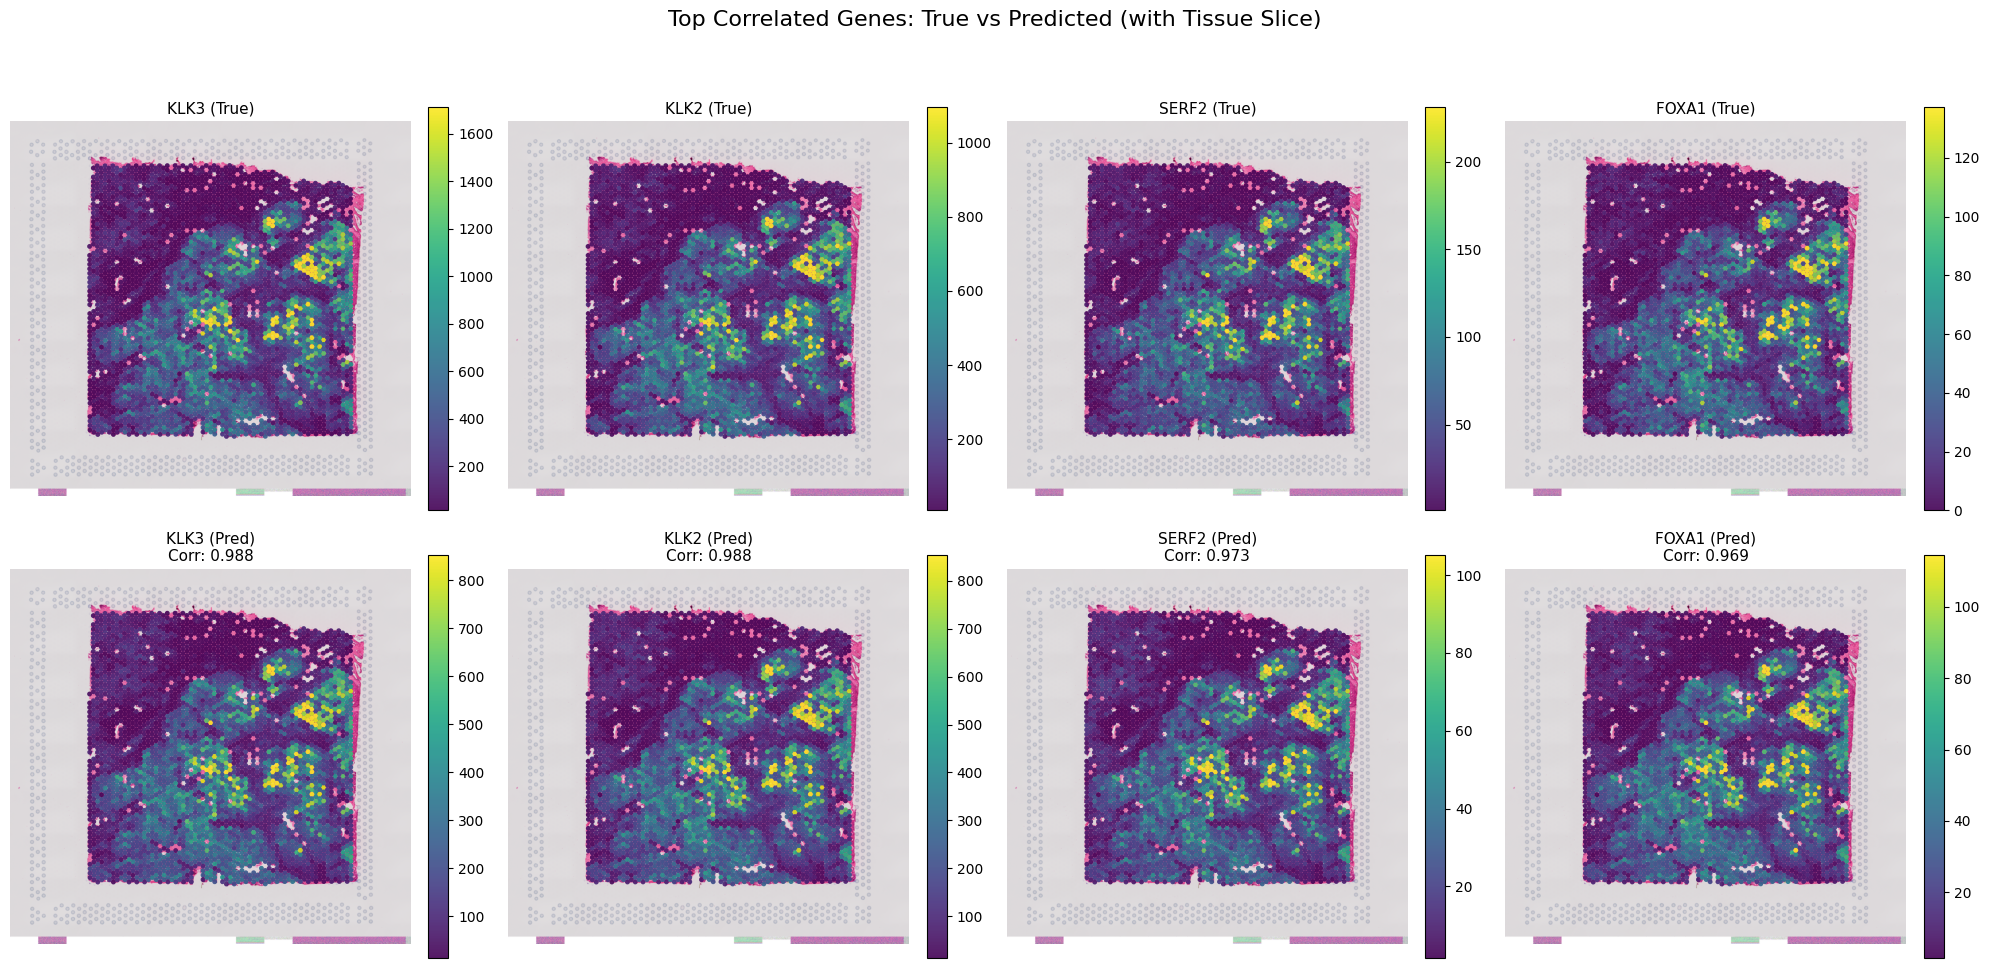

In [10]:
# === Visualizing Spatial Gene-Expression (Top-4) WITH Tissue Slice Background ===
import os
from pathlib import Path

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Optional: background loading
from PIL import Image


def robust_vmin_vmax(arr, p_low=1, p_high=99):
    """
    Compute (vmin, vmax) from this panel's values only (robust percentiles).
    Each panel (each subplot) can have its own scale.
    """
    a = np.asarray(arr, dtype=float)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return 0.0, 1.0

    vmin, vmax = np.percentile(a, [p_low, p_high])
    if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
        vmin, vmax = float(np.min(a)), float(np.max(a))
        if vmin == vmax:
            eps = 1e-6 if vmin == 0 else abs(vmin) * 1e-6
            vmin, vmax = vmin - eps, vmax + eps
    return vmin, vmax


def pearson_corr(a, b):
    a = a - a.mean()
    b = b - b.mean()
    denom = np.sqrt((a * a).sum()) * np.sqrt((b * b).sum())
    if denom == 0:
        return np.nan
    return float((a * b).sum() / denom)


# ----------------------------
# 0) Paths & IDs
# ----------------------------
TEST_ID = test_slide_id if "test_slide_id" in globals() else "INT28"

if "ROOT" in globals():
    ROOT = Path(ROOT)
else:
    ROOT = Path(os.environ.get("MORPHO_VC_ROOT", "../")).expanduser().resolve()

if "data_dir" in globals():
    data_root = Path(data_dir)
else:
    data_root = ROOT / "data"

if "hest_dir" in globals():
    HEST_DIR = Path(hest_dir)
else:
    HEST_DIR = data_root / "hest_data"

DATA_DIR = data_root / "spatial_data"

h5ad_path = DATA_DIR / f"{TEST_ID}.h5ad"
if not h5ad_path.exists():
    # fallback (keep your style)
    h5ad_path = Path(f"../../data/spatial_data/{TEST_ID}.h5ad").resolve()

print(f"Loading spatial data from: {h5ad_path}")

# ----------------------------
# 1) Load spatial coords (aligned with spot_ids)
# ----------------------------
try:
    if "datas" in globals() and TEST_ID in datas:
        adata = datas[TEST_ID].adata
    else:
        adata = sc.read_h5ad(h5ad_path)

    if "datasets" in globals() and TEST_ID in datasets:
        slide_ds = datasets[TEST_ID]
        spot_ids = slide_ds.spot_ids
        name_to_idx = {sid: i for i, sid in enumerate(adata.obs_names)}
        coords = np.array([adata.obsm["spatial"][name_to_idx[sid]] for sid in spot_ids])
    else:
        coords = adata.obsm["spatial"]
        print("[WARN] datasets not found; using adata.obsm['spatial'] order.")

    x, y = coords[:, 0], coords[:, 1]

    min_x, min_y = coords.min(axis=0)
    max_x, max_y = coords.max(axis=0)
    print(f"Coords Range: X[{min_x:.1f}, {max_x:.1f}], Y[{min_y:.1f}, {max_y:.1f}]")
except Exception as e:
    print(f"[ERROR] Failed to load spatial coords: {e}")
    # last-resort fallback for debugging
    x, y = np.random.rand(pred_bag.shape[0]), np.random.rand(pred_bag.shape[0])
    min_x, min_y, max_x, max_y = x.min(), y.min(), x.max(), y.max()

# ----------------------------
# 1.5) Align predictions with coords
# ----------------------------
pred_bag_slide, true_bag_slide = pred_bag, true_bag
if pred_bag_slide.shape[0] != len(x):
    raise ValueError(
        f"Mismatch: coords={len(x)} vs pred_bag={pred_bag_slide.shape[0]} for {TEST_ID}"
    )

# ----------------------------
# 2) Try load WSI background (tissue slice)
# ----------------------------
bg_img = None
bg_extent = None  # (xmin, xmax, ymax, ymin) or (xmin, xmax, ymin, ymax) depending on usage

wsi_files = list((HEST_DIR / "wsis").glob(f"{TEST_ID}.*"))
if len(wsi_files) > 0:
    wsi_path = wsi_files[0]
    print(f"Found WSI: {wsi_path}")

    # Try OpenSlide first (best for .svs/.tiff)
    try:
        import openslide  # noqa: F401

        slide = openslide.OpenSlide(str(wsi_path))
        w0, h0 = slide.dimensions
        print(f"WSI dims (original): {w0} x {h0}")

        # build a thumbnail for plotting speed
        thumb_w = 2000
        scale = thumb_w / w0
        thumb_h = int(h0 * scale)
        bg_img = slide.get_thumbnail((thumb_w, thumb_h))

        # Decide extent strategy:
        # If coords look like they live in pixel space [0..w0, 0..h0], use pixel extent.
        # Else, stretch thumbnail into coords bounding box.
        in_pixel_space = (
            (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
            (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
        )

        if in_pixel_space:
            # same convention as your reference code: y-down image coordinates
            bg_extent = (0, w0, h0, 0)
            print("Using pixel-space extent (0..W, H..0) for alignment.")
        else:
            bg_extent = (min_x, max_x, max_y, min_y)
            print("Coords not in pixel space; stretching background to coords bounding box.")

    except Exception as e:
        print(f"OpenSlide failed ({e}), trying PIL...")

        try:
            Image.MAX_IMAGE_PIXELS = None
            img = Image.open(wsi_path)
            w0, h0 = img.size
            print(f"WSI dims (PIL original): {w0} x {h0}")

            img.thumbnail((2000, 2000))
            bg_img = img

            in_pixel_space = (
                (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
                (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
            )
            if in_pixel_space:
                bg_extent = (0, w0, h0, 0)
                print("Using pixel-space extent (0..W, H..0) for alignment.")
            else:
                bg_extent = (min_x, max_x, max_y, min_y)
                print("Coords not in pixel space; stretching background to coords bounding box.")
        except Exception as e2:
            print(f"[WARNING] PIL background load failed: {e2}")
            bg_img, bg_extent = None, None
else:
    print("[INFO] No WSI found under:", (HEST_DIR / "wsis"))

# ----------------------------
# 3) Pick Top-4 genes by correlation
# ----------------------------
if "common_genes" not in globals():
    raise NameError("common_genes not found. Run the geneset cell first.")

gene_corrs = []
for i in range(pred_bag_slide.shape[1]):
    corr = pearson_corr(pred_bag_slide[:, i], true_bag_slide[:, i])
    gene_corrs.append(corr)

valid = [(i, c) for i, c in enumerate(gene_corrs) if not np.isnan(c)]
sorted_genes = sorted(valid, key=lambda t: t[1], reverse=True)
top4_genes = sorted_genes[:4]
n_show = len(top4_genes)
if n_show == 0:
    raise ValueError("top4_genes is empty. Check prediction outputs.")

# ----------------------------
# 4) Plot (2 rows: True vs Pred) + background slice
#    - NOTE: NO shared scaling: each panel has its own vmin/vmax
# ----------------------------
fig, axes = plt.subplots(2, n_show, figsize=(5 * n_show, 10))
if n_show == 1:
    axes = np.array(axes).reshape(2, 1)

fig.suptitle("Top Correlated Genes: True vs Predicted (with Tissue Slice)", fontsize=16, y=0.98)

for i, (gene_idx, corr) in enumerate(top4_genes):
    gene_name = common_genes[gene_idx]

    gt_expr = true_bag_slide[:, gene_idx]
    pr_expr = pred_bag_slide[:, gene_idx]

    vmin_gt, vmax_gt = robust_vmin_vmax(gt_expr, p_low=1, p_high=99)
    vmin_pr, vmax_pr = robust_vmin_vmax(pr_expr, p_low=1, p_high=99)

    # --- Row 1: Ground Truth ---
    ax_gt = axes[0, i]
    if bg_img is not None and bg_extent is not None:
        ax_gt.imshow(bg_img, extent=bg_extent)
    sc_gt = ax_gt.scatter(
        x, y, c=gt_expr, cmap="viridis", s=12, alpha=0.9,
        vmin=vmin_gt, vmax=vmax_gt, edgecolors="none"
    )
    ax_gt.set_title(f"{gene_name} (True)", fontsize=11)
    ax_gt.axis("off")
    if bg_img is None:
        ax_gt.invert_yaxis()
    plt.colorbar(sc_gt, ax=ax_gt, fraction=0.046, pad=0.04)

    # --- Row 2: Prediction ---
    ax_pr = axes[1, i]
    if bg_img is not None and bg_extent is not None:
        ax_pr.imshow(bg_img, extent=bg_extent)
    sc_pr = ax_pr.scatter(
        x, y, c=pr_expr, cmap="viridis", s=12, alpha=0.9,
        vmin=vmin_pr, vmax=vmax_pr, edgecolors="none"
    )
    ax_pr.set_title(f"{gene_name} (Pred)\nCorr: {corr:.3f}", fontsize=11)
    ax_pr.axis("off")
    if bg_img is None:
        ax_pr.invert_yaxis()
    plt.colorbar(sc_pr, ax=ax_pr, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
